<a href="https://colab.research.google.com/github/aniruddh-alt/NewsBERT---Fake-News-Classifier/blob/main/FakeNewsDetection_NewsBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook aims to implement fake news detection using RoBERTa transformer. We wll be implementing transfer learning and finetune RoBERTa to perform fake news detection.


In [1]:
!pip install transformers pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 150.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [2]:
!pip install scikit-learn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import transformers
from transformers import AutoTokenizer, AutoModel, RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, RobertaModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
from google.colab import drive, files

In [4]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mkdir -p ~/.config/kaggle
!mv kaggle.json ~/.config/kaggle/

In [6]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

Dataset URL: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
License(s): CC-BY-NC-SA-4.0
 68% 28.0M/41.0M [00:00<00:00, 120MB/s] 
100% 41.0M/41.0M [00:00<00:00, 104MB/s]


In [7]:
!unzip fake-and-real-news-dataset.zip

Archive:  fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [8]:
true_data = pd.read_csv('True.csv')
fake_data = pd.read_csv('Fake.csv')

In [9]:
true_data

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [10]:
fake_data

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [11]:
true_data['target'] = ['True']*len(true_data)
fake_data['target'] = ['Fake']*len(fake_data)

In [12]:
data = pd.concat([true_data, fake_data], ignore_index=True).sample(frac=1).reset_index(drop=True)

In [13]:
data

,title,text,subject,date,target
0,Boiler Room #94 – President Trump & The Great ...,Tune in to the Alternate Current Radio Network...,US_News,"January 27, 2017",Fake
1,HILLARY’S #1 AIDE HUMA ABEDIN: Ties To Terrori...,Please check out our previous in-depth look at...,politics,"Oct 31, 2016",Fake
2,BURIED BY MEDIA: Aide To Leftist US Congressma...,Just when you thought Muslims had cornered the...,politics,"Oct 14, 2015",Fake
3,Danish divers find arm assumed to be that of d...,COPENHAGEN (Reuters) - Divers searching waters...,worldnews,"November 29, 2017",True
4,British protesters tell Trump from Tower Bridg...,LONDON (Reuters) - A banner reading “Build bri...,politicsNews,"January 20, 2017",True
...,...,...,...,...,...
44893,WATCH: Cop Caught On Video Body-Slamming 12-Y...,A Texas cop is under fire after video surfaced...,News,"April 7, 2016",Fake
44894,Justice Department in civil rights probe of Ar...,PHOENIX (Reuters) - The U.S. Department of Jus...,politicsNews,"April 5, 2016",True
44895,CNN INTERVIEW TURNS INTO SCREAMING MATCH When ...,(From CNN) New video captured hours before Mic...,politics,"Mar 13, 2017",Fake
44896,WATCH JOHN KERRY’S FEAR MONGERING ON IRAN DEAL...,If denied by Congress it would have profound ...,Government News,"Sep 2, 2015",Fake


In [14]:
data['label'] = data['target'].apply(lambda x: 1 if x == 'Fake' else 0)
data

,title,text,subject,date,target,label
0,Boiler Room #94 – President Trump & The Great ...,Tune in to the Alternate Current Radio Network...,US_News,"January 27, 2017",Fake,1
1,HILLARY’S #1 AIDE HUMA ABEDIN: Ties To Terrori...,Please check out our previous in-depth look at...,politics,"Oct 31, 2016",Fake,1
2,BURIED BY MEDIA: Aide To Leftist US Congressma...,Just when you thought Muslims had cornered the...,politics,"Oct 14, 2015",Fake,1
3,Danish divers find arm assumed to be that of d...,COPENHAGEN (Reuters) - Divers searching waters...,worldnews,"November 29, 2017",True,0
4,British protesters tell Trump from Tower Bridg...,LONDON (Reuters) - A banner reading “Build bri...,politicsNews,"January 20, 2017",True,0
...,...,...,...,...,...,...
44893,WATCH: Cop Caught On Video Body-Slamming 12-Y...,A Texas cop is under fire after video surfaced...,News,"April 7, 2016",Fake,1
44894,Justice Department in civil rights probe of Ar...,PHOENIX (Reuters) - The U.S. Department of Jus...,politicsNews,"April 5, 2016",True,0
44895,CNN INTERVIEW TURNS INTO SCREAMING MATCH When ...,(From CNN) New video captured hours before Mic...,politics,"Mar 13, 2017",Fake,1
44896,WATCH JOHN KERRY’S FEAR MONGERING ON IRAN DEAL...,If denied by Congress it would have profound ...,Government News,"Sep 2, 2015",Fake,1


In [15]:
data.value_counts('label')

,count
label,
1,23481
0,21417


([<matplotlib.patches.Wedge at 0x7ff71d6c7910>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

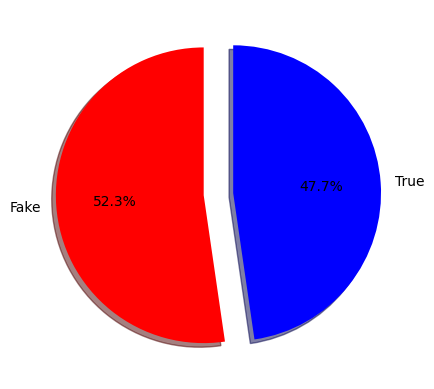

In [16]:
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['red','blue'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')


In [17]:
from sklearn.model_selection import train_test_split

X = data['title']
y = data['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=data['target'])
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [18]:
model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
MAX_LENGTH = 15

### tokenizing the input (titles from dataset)

tokenize_train = tokenizer.batch_encode_plus(X_train.tolist(),
                                             max_length=MAX_LENGTH,
                                             pad_to_max_length=True,
                                             truncation=True)
tokenize_val = tokenizer.batch_encode_plus(X_val.tolist(),
                                             max_length=MAX_LENGTH,
                                             pad_to_max_length=True,
                                             truncation=True)
tokenize_test = tokenizer.batch_encode_plus(X_test.tolist(),
                                             max_length=MAX_LENGTH,
                                             pad_to_max_length=True,
                                             truncation=True)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [20]:
tokenize_test.keys() ### viewing the strcture of tokenized data

dict_keys(['input_ids', 'attention_mask'])

In [21]:
### Convert them to pytorch tensors and create new dataset.
### Train data
train_seq = torch.tensor(tokenize_train['input_ids'])
train_mask = torch.tensor(tokenize_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)
### Validation data
val_seq = torch.tensor(tokenize_val['input_ids'])
val_mask = torch.tensor(tokenize_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=32)
### Test Data
test_seq = torch.tensor(tokenize_test['input_ids'])
test_mask = torch.tensor(tokenize_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())
test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=32)

In [22]:
### freezing the parameters of the ROBERTA model and loading roBERTa NN

class RoBERTaNN(nn.Module):
    def __init__(self, num_classes):
        super(RoBERTaNN, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')

        # Freeze the RoBERTa model parameters
        for param in self.roberta.parameters():
            param.requires_grad = False

        self.drop = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(self.roberta.config.hidden_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, sent_id, mask):
        # Get hidden states from RoBERTa
        outputs = self.roberta(input_ids=sent_id, attention_mask=mask)
        # Use the pooled output
        pooler_output = outputs.pooler_output
        x = self.drop(pooler_output)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [23]:
model = RoBERTaNN(num_classes = 2) # binary output

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=1e-5)
cross_entropy = nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
def train():
  model.train()
  total_loss, total_accuracy = 0,0

  for step, batch in enumerate(train_dataloader):

    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    batch = [r for r in batch]
    sent_id, mask, labels = batch

    model.zero_grad()

    preds = model(sent_id, mask)

    loss = cross_entropy(preds, labels)
    total_loss = total_loss + loss.item()

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    preds = preds.detach().cpu().numpy()

  avg_loss = total_loss / len(train_dataloader)
  return avg_loss


In [26]:
def evaluate():
  model.eval()
  total_loss, total_accuracy = 0,0

  for step, batch in enumerate(val_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    batch = [t for t in batch]
    sent_id, mask, labels = batch

    with torch.no_grad():
      preds = model(sent_id, mask)

      loss = cross_entropy(preds, labels)
      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

  avg_loss = total_loss / len(val_dataloader)

  return avg_loss

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
model_save_path = '/content/drive/MyDrive/saved_weights.pt'

In [29]:
best_valid_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(2):
  print('\n Epoch {:} / {:}'.format(epoch + 1, 5))
  train_loss = train()
  val_loss = evaluate()
  if val_loss < best_valid_loss:
    best_valid_loss = val_loss
    torch.save(model.state_dict(), model_save_path)

  train_losses.append(train_loss)
  val_losses.append(val_loss)


 Epoch 1 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

 Epoch 2 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   

In [31]:
model.state_dict()

             ('fc2.weight',
              tensor([[-4.5365e-02, -4.9434e-03,  1.4873e-03,  ...,  3.9545e-02,
                        1.7834e-02,  3.4070e-02],
                      [-3.8185e-02, -6.1271e-03,  2.0702e-02,  ...,  3.1392e-02,
                        4.6106e-03,  4.6406e-03],
                      [-2.6754e-02, -3.2976e-02,  1.6708e-02,  ..., -3.4882e-02,
                        4.1422e-02, -5.0461e-03],
                      ...,
                      [ 2.9956e-02,  7.5908e-03,  3.1794e-05,  ...,  2.1350e-02,
                       -2.3998e-02,  3.2747e-02],
                      [ 4.3417e-03, -2.4135e-03,  9.3074e-03,  ..., -2.7712e-02,
                       -1.0996e-02,  2.0409e-02],
                      [-7.2454e-03, -1.4505e-02, -1.2721e-02,  ...,  4.2478e-02,
                        1.9362e-02,  4.2976e-02]])),
             ('fc2.bias',
              tensor([-0.0336, -0.0398, -0.0113, -0.0099, -0.0089, -0.0385, -0.0268, -0.0188,
                       0.0424,  0.01

In [33]:
# load weights of best model

from sklearn.metrics import classification_report # Import the classification_report function
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      3212
           1       0.52      1.00      0.69      3523

    accuracy                           0.52      6735
   macro avg       0.76      0.50      0.35      6735
weighted avg       0.75      0.52      0.36      6735



In [34]:
# testing on unseen data
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers"                          # True
                    ]
# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)
preds

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


array([1, 1, 1, 1])